# Inference on simulated CHARA data on a "Uniform disk" star 

In this notebook, I show how to infer the radius of a "uniform disk" star with simulated squared visibility data from a CHARA-PAVO-like instrument. I will use jax for the model and numpyro for the sampling.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#this is the way I've found to get jax to use multiple CPU cores on Apple Silicon
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=2"

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap

import numpyro
from numpyro import distributions as dist, infer

import arviz as az

import corner
from jax.config import config
config.update("jax_enable_x64", True)

from numpy import genfromtxt

## Getting the CHARA baselines:

Since we are simulating CHARA data, I have gotten the baselines from the CHARA website and put them in a csv file, which I will read in. To simulate taking multiple observations with different position angles, I will simply rotate and duplicate each baseline by 5 degrees and repeat 10 times. A more realistic scenario would involve projecting the baselines onto the changing star's position on sky, but perhaps this is an observation of Polaris ;).

In [2]:
_, baseline, pa = genfromtxt('chara.csv', delimiter=',').T

In [3]:
#getting the U and V planes
baseline = np.concatenate([baseline for i in range(10)])
pa = np.concatenate([pa+i*5 for i in range(10)])
u = baseline*np.cos(np.radians(pa))
v = baseline*np.sin(np.radians(pa))
x = jnp.hypot(u,v)
theta = jnp.arctan(v/u)

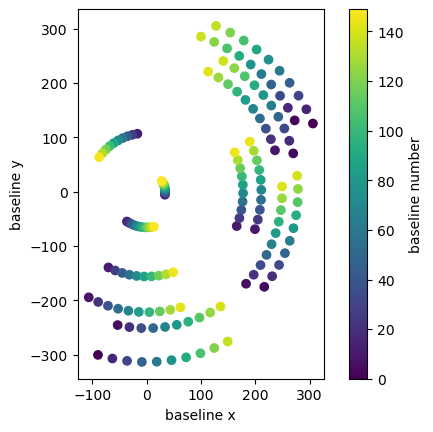

In [4]:
plt.scatter(u,v,c=np.arange(len(u)))
plt.xlabel("baseline x")
plt.ylabel("baseline y")
plt.gca().set_aspect('equal', adjustable='box')
cbar = plt.colorbar()
cbar.set_label('baseline number')

## Inference on a single star:

### Plotting the simulated dataset with gaussian scatter alongside the truth

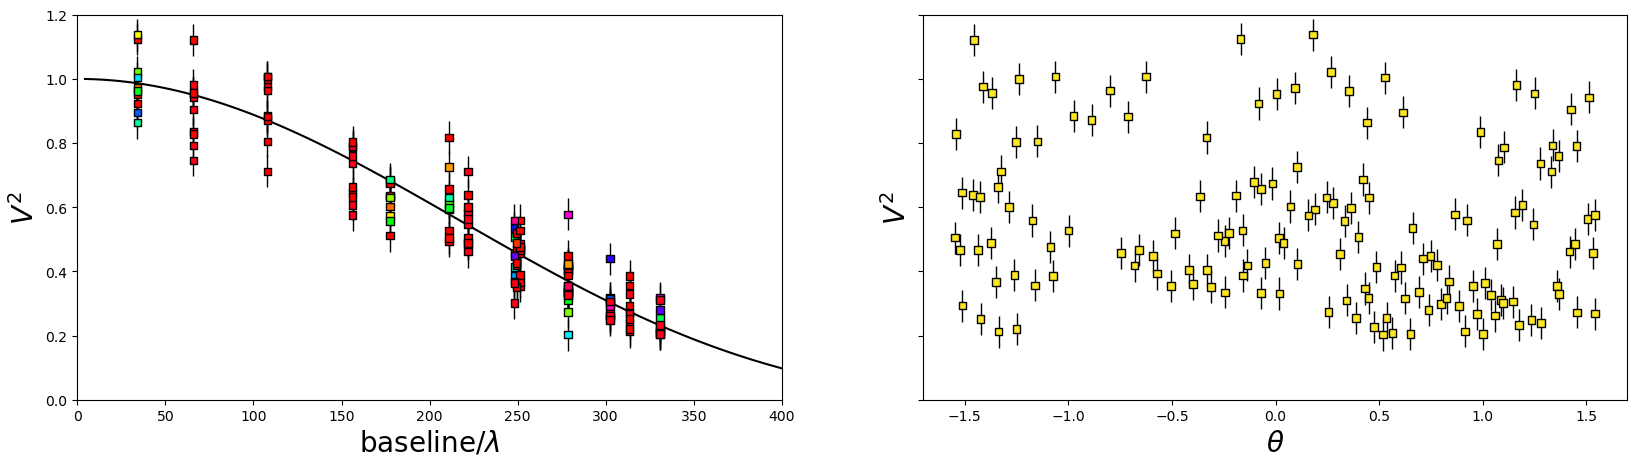

In [5]:
mas2rad = jnp.pi / 180.0 / 3600.0/ 1000.0

def j1(x):
    return jax.scipy.special.bessel_jn(x,v=1,n_iter=50)[1]

def j0(x):
    return jax.scipy.special.bessel_jn(x,v=0,n_iter=50)[0]

@jit
@vmap
def jinc(x):
    dummy = 2*(j1(x)/x)
    return dummy
    #return jax.lax.select(~jnp.isfinite(dummy), 1., dummy) 

def vis_gauss(d,u,v):
    d = mas2rad*d
    return jnp.exp(-(jnp.pi*d*jnp.sqrt(u**2+v**2))**2/4./jnp.log(2))

def vis_ud(d,u,v):
    r = jnp.sqrt(u**2+v**2)
    diam = d*mas2rad
    t = jinc(jnp.pi*diam*r)
    return t

#parameters of the disk
true_params = [0.45]
wavel = 1e-6


# For reproducibility, let's set the random number seed and generate the data:
np.random.seed(12)

yerr = 0.05 * np.ones_like(x)

#gaussian
y = vis_ud(true_params[0], u/wavel, v/wavel) + yerr * np.random.randn(len(x)) #np.exp(-((x)**2)/(2*true_params[0]**2)) + yerr * np.random.randn(len(x))


# Then save the *true* line.
u0, v0 = (np.linspace(0, jnp.max(u), 100), np.linspace(0, jnp.max(v), 100))
x0 = jnp.hypot(u0,v0)
y0 = vis_ud(true_params[0], u0/wavel, v0/wavel)

cmap = plt.get_cmap("hsv")
cmap2 = plt.get_cmap("viridis")



def plot_data():
    fig, ax = plt.subplots(1,2, figsize=(20,5), sharey=True)
    ax[0].errorbar(x, y**2, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
    ax[0].scatter(x, y**2, marker="s", s=30, edgecolor="k", zorder=1000, c=cmap(theta))
    ax[0].plot(x0, y0**2, color="k", lw=1.5)
    ax[0].set_xlabel("baseline/$\lambda$", fontsize=20)
    ax[0].set_ylabel("$V^2$", fontsize=20)
    ax[0].set_ylim(0, 1.2)
    ax[0].set_xlim(0,400)
    
    ax[1].errorbar(theta, y**2, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
    ax[1].scatter(theta, y**2, marker="s", s=30, edgecolor="k", zorder=1000, c=cmap2(x))
    ax[1].set_xlabel(r"$\theta$", fontsize=20)
    ax[1].set_ylabel("$V^2$", fontsize=20)
    ax[1].set_ylim(0, 1.2)


plot_data()

### The numpyro uniform disk model:

Here I code up the numpyro model, which samples and performs inference given the model and a set of baselines

In [6]:
numpyro.set_host_device_count(2)


def model(u,v, yerr, y=None, wavel=1e-6):
    # These are the parameters that we're fitting and we're required to define explicit
    # priors using distributions from the numpyro.distributions module.
    diam = numpyro.sample("diam", dist.Uniform(0, 5))


    # Then we specify the sampling distribution for the data, or the likelihood function.
    # Here we're using a numpyro.plate to indicate that the data are independent. This
    # isn't actually necessary here and we could have equivalently omitted the plate since
    # the Normal distribution can already handle vector-valued inputs. But, it's good to
    # get into the habit of using plates because some inference algorithms or distributions
    # can take advantage of knowing this structure.
    with numpyro.plate("data", len(u)):
        numpyro.sample("y", dist.Normal(vis_ud(diam,u/wavel,v/wavel)**2, yerr), obs=y**2)

In [7]:
# Using the model above, we can now sample from the posterior distribution using the No
# U-Turn Sampler (NUTS).
sampler = infer.MCMC(
    infer.NUTS(model),
    num_warmup=2000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)
%time sampler.run(jax.random.PRNGKey(0), u, v, yerr, y=y)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

CPU times: user 2.38 s, sys: 53 ms, total: 2.43 s
Wall time: 1.9 s


In [8]:
inf_data = az.from_numpyro(sampler)
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
diam,0.452,0.003,0.447,0.458,0.0,0.0,1500.0,2398.0,1.0


array([[<AxesSubplot:title={'center':'diam'}>,
        <AxesSubplot:title={'center':'diam'}>]], dtype=object)

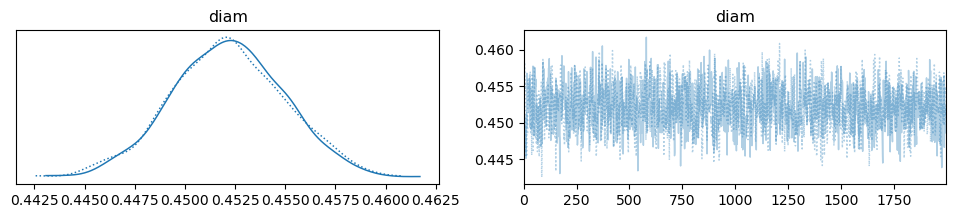

In [9]:
az.plot_trace(inf_data, var_names=('diam'))

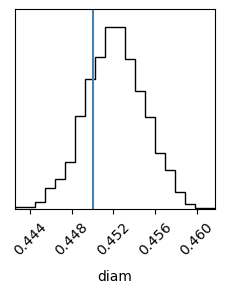

In [10]:
corner.corner(inf_data, var_names=["diam"], truths=true_params);

## Inference on an ensemble of stars:


Next, I create a set of stars, each with their own radii and gaussian noise, and attempt to infer their radii within the same model. This may seem like a trivial addition to the previous example of a single star, but it will be crucial for the next step--(hierarchical) systematics inference on an ensemble of stars.

In [11]:
np.random.seed(40)
num_stars = 5
diams = np.random.uniform(0,3,num_stars)
#parameters of the Gaussian

# For reproducibility, let's set the random number seed and generate the data:

yerr = 0.05

#gaussian
y = jnp.array([vis_ud(diam,u/wavel,v/wavel) for diam in diams]) + yerr * np.random.randn(num_stars,x.shape[0])


# Then save the *true* line.
u0 = np.linspace(0, jnp.max(u)+5.0, 100)
v0 = np.linspace(0, jnp.max(v)+5.0, 100)
y0 = jnp.array([vis_ud(diam,u0/wavel,v0/wavel) for diam in diams])

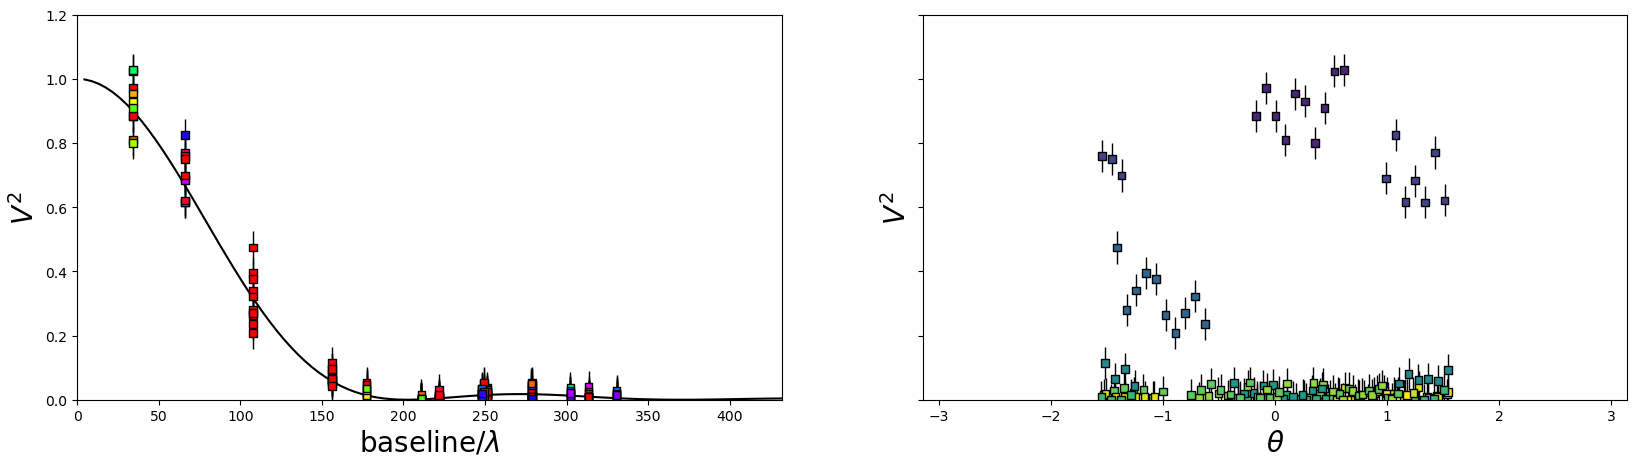

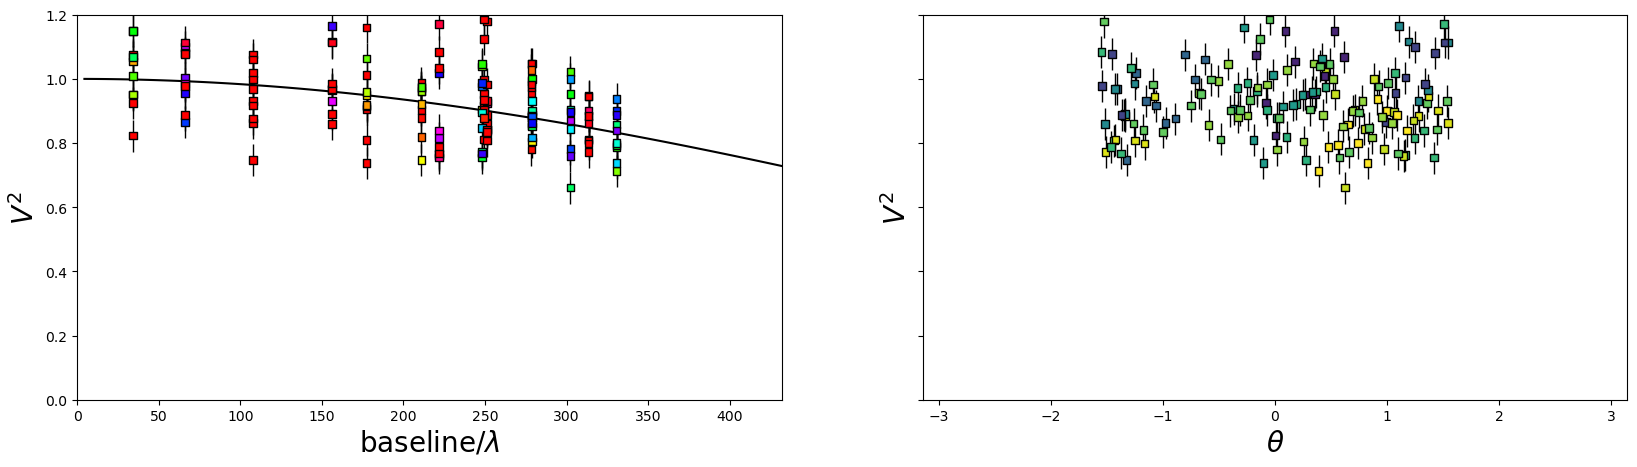

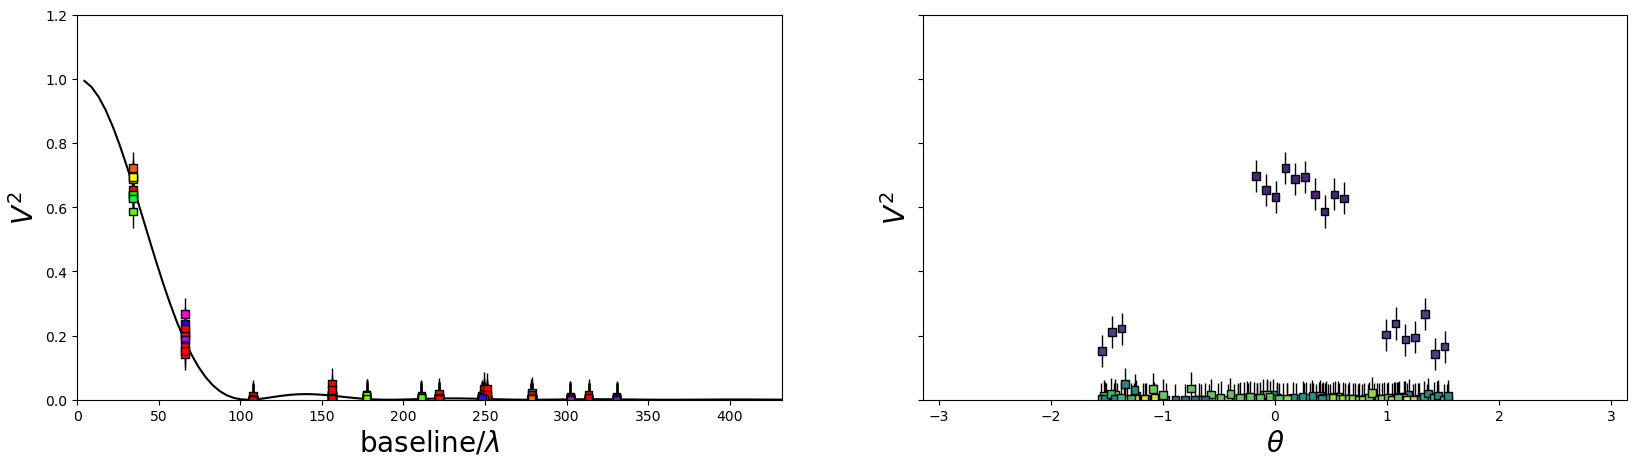

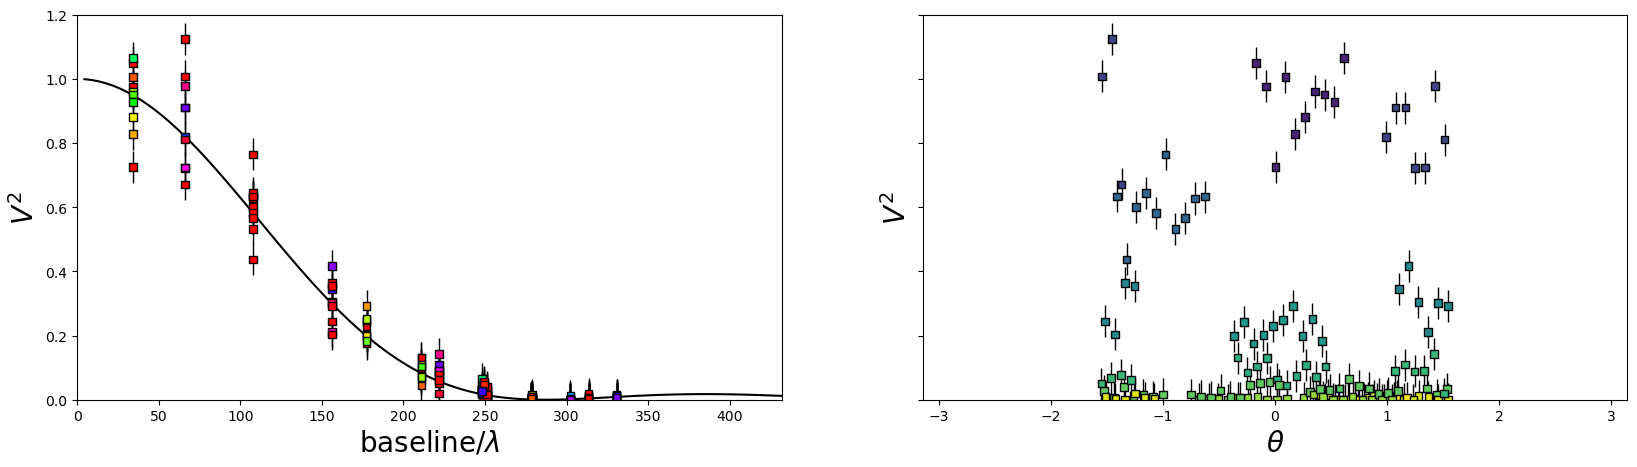

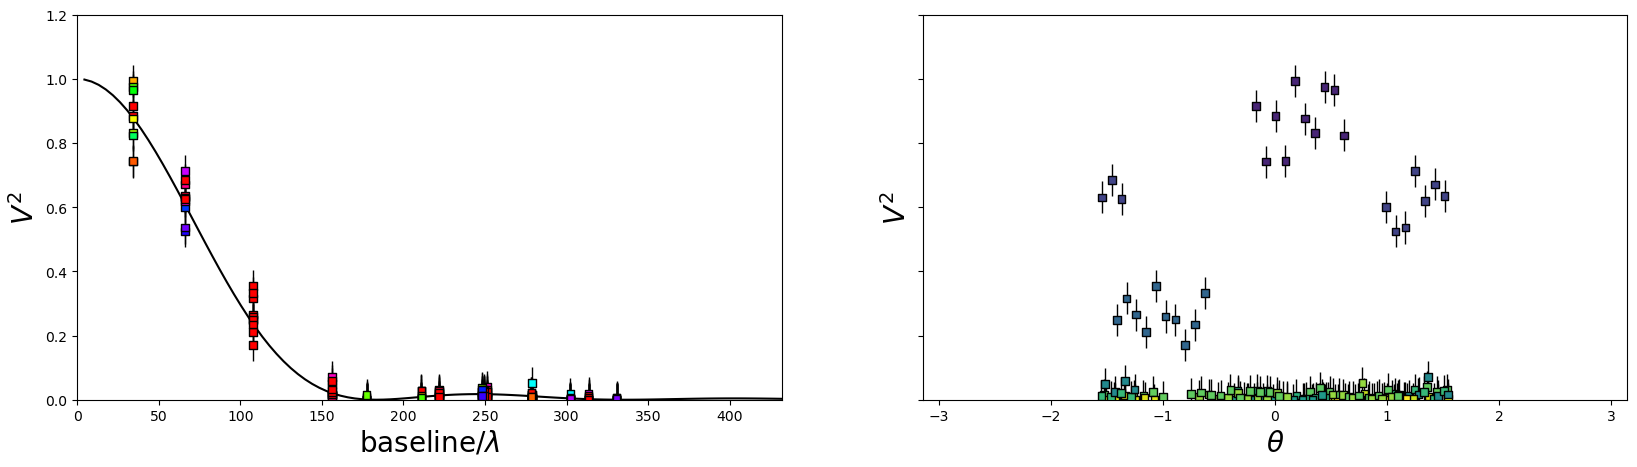

In [13]:
def plot_data(x, y, x0, y0, yerr):
    fig, ax = plt.subplots(1,2, figsize=(20,5), sharey=True)
    
    ax[0].errorbar(x, y**2, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
    ax[0].scatter(x, y**2, marker="s", s=30, edgecolor="k", zorder=1000, c=cmap(theta/theta.max()))
    ax[0].plot(x0, y0**2, color="k", lw=1.5)
    ax[0].set_xlabel("baseline/$\lambda$", fontsize=20)
    ax[0].set_ylabel("$V^2$", fontsize=20)
    ax[0].set_ylim(0, 1.2)
    ax[0].set_xlim(0, jnp.max(x0))
    
    ax[1].errorbar(theta, y**2, yerr=yerr, fmt=",k", ms=0, capsize=0, lw=1, zorder=999)
    ax[1].scatter(theta, y**2, marker="s", s=30, edgecolor="k", zorder=1000, c=cmap2(x/x.max()))
    ax[1].set_xlabel(r"$\theta$", fontsize=20)
    ax[1].set_ylabel(r"$V^2$", fontsize=20)
    ax[1].set_ylim(0, 1.2)
    ax[1].set_xlim(-np.pi, np.pi)
    
for i, diam in enumerate(diams):
    plot_data(x,y[i], x0, y0[i], yerr)

In [14]:
def model_multi(u,v, yerr, y=None):
    # These are the parameters that we're fitting and we're required to define explicit
    # priors using distributions from the numpyro.distributions module.


    # Then we specify the sampling distribution for the data, or the likelihood function.
    # Here we're using a numpyro.plate to indicate that the data are independent. This
    # isn't actually necessary here and we could have equivalently omitted the plate since
    # the Normal distribution can already handle vector-valued inputs. But, it's good to
    # get into the habit of using plates because some inference algorithms or distributions
    # can take advantage of knowing this structure.
    with numpyro.plate("stars", y.shape[0],dim=-2):
        diam = numpyro.sample("diam", dist.Uniform(0, 5))
        
    with numpyro.plate("data",y.shape[1]):
        numpyro.sample("y", dist.Normal(vis_ud(diam,u/wavel,v/wavel)**2, yerr), obs=y**2)

In [15]:
# Using the model above, we can now sample from the posterior distribution using the No
# U-Turn Sampler (NUTS).
sampler = infer.MCMC(
    infer.NUTS(model_multi),
    num_warmup=2000,
    num_samples=2000,
    num_chains=2,
    progress_bar=True,
)
%time sampler.run(jax.random.PRNGKey(0), u, v, yerr, y=y)

/Users/uqsdhola/opt/anaconda3/lib/python3.9/site-packages/jax/_src/linear_util.py:165: UserWarning: Missing a plate statement for batch dimension -2 at site 'y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  ans = self.f(*args, **dict(self.params, **kwargs))


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

CPU times: user 9.28 s, sys: 56.9 ms, total: 9.34 s
Wall time: 5.54 s


In [16]:
inf_data = az.from_numpyro(sampler)
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"diam[0, 0]",1.213,0.016,1.183,1.244,0.000,0.0,5544.0,3182.0,1.0
"diam[1, 0]",0.157,0.004,0.150,0.164,0.000,0.0,5818.0,3030.0,1.0
"diam[2, 0]",2.391,0.041,2.310,2.467,0.001,0.0,5528.0,2815.0,1.0
"diam[3, 0]",0.851,0.008,0.835,0.867,0.000,0.0,6019.0,3095.0,1.0
"diam[4, 0]",1.335,0.019,1.299,1.370,0.000,0.0,5397.0,2777.0,1.0


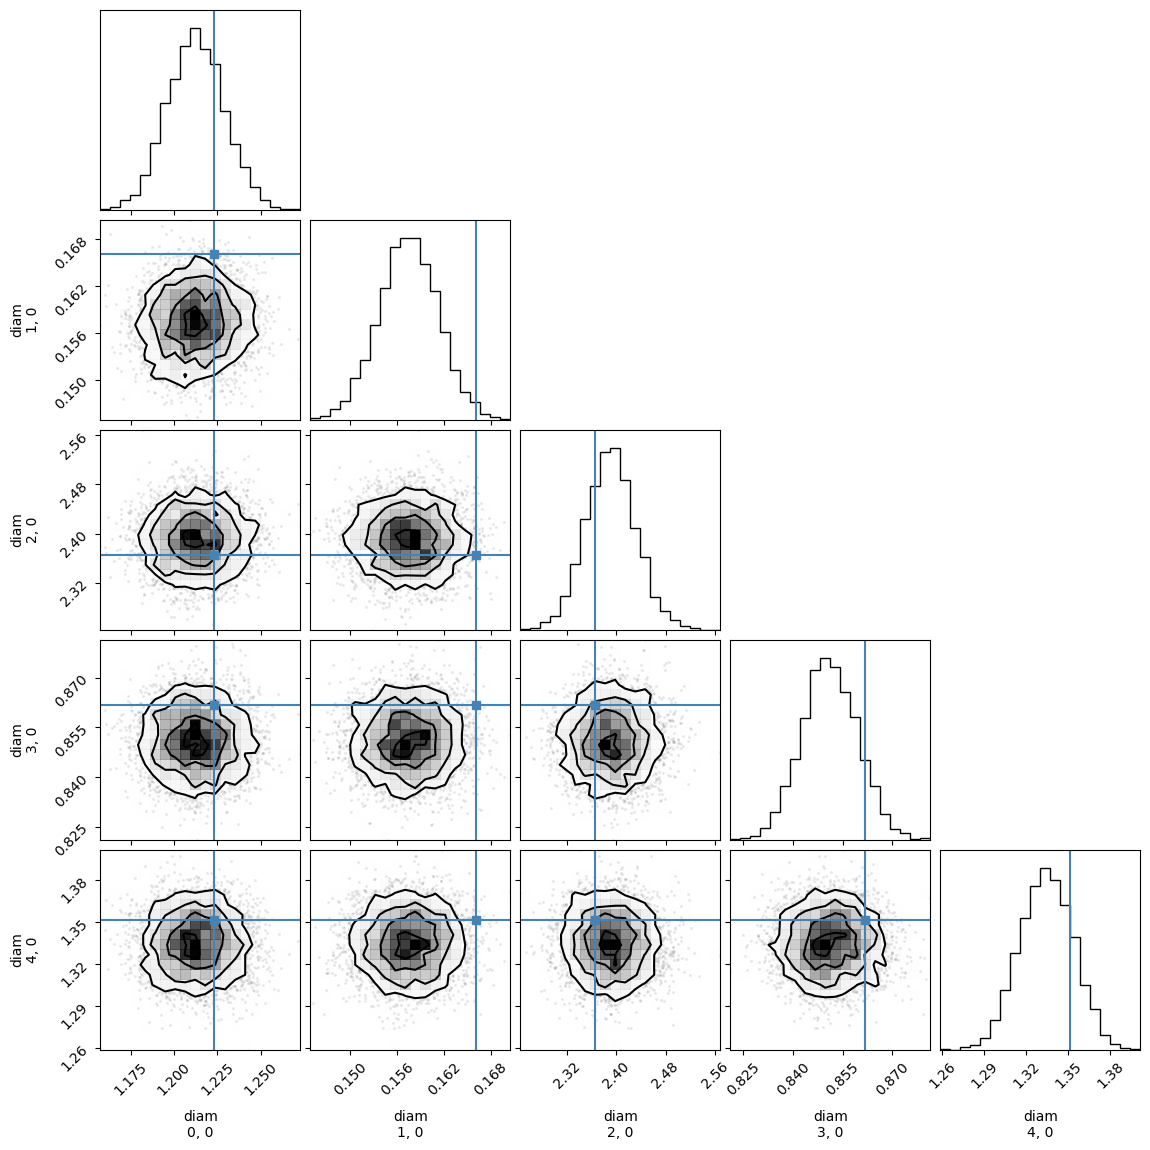

In [17]:
corner.corner(inf_data, var_names=["diam"], truths=diams);

As we can see, we recover the radii of these stars quite well!